In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7815264017180005768
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7288174037804847148
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [5]:
import pathlib
import string
import re
import io
import os
from string import digits
from numpy import array,argmax,random,take
import pickle as pkl
from pickle import dump
from pickle import load
from numpy.random import rand
from numpy.random import shuffle
from unicodedata import normalize
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Input, Concatenate, TimeDistributed, Bidirectional, TextVectorization
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
%matplotlib inline
import seaborn as sns
from nltk.translate.bleu_score import corpus_bleu
sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from pickle import dump,load
import pickle
import warnings
warnings.filterwarnings('ignore')

In [7]:
text_file ='/content/drive/MyDrive/NeuralMachineTranslation/datasets/hin.txt'

In [8]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, hin = line.split("\t")[:2]
    hin = "[start] " + hin + " [end]"
    text_pairs.append((eng, hin))
  
print(text_pairs[1])

('Duck!', '[start] झुको! [end]')


In [ ]:
for i in range(5):
    print(text_pairs[i])

('Wow!', '[start] वाह! [end]')
('Duck!', '[start] झुको! [end]')
('Duck!', '[start] बतख़! [end]')
('Help!', '[start] बचाओ! [end]')
('Jump.', '[start] उछलो. [end]')


In [ ]:
random.shuffle(text_pairs)
train_pairs = text_pairs[:2500]
val_pairs = text_pairs[2500 : 2834]
test_pairs = text_pairs[2834 : 2934]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

2934 total pairs
2500 training pairs
334 validation pairs
100 test pairs


In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/input_eng.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/input_eng.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_eng = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_eng = TextVectorization.from_config(pickle_obj_eng["config"])
vector_eng.set_vocabulary(pickle_obj_eng["vocabulary"])
vector_eng.set_weights(pickle_obj_eng["weights"])

# NOW "vector" can be used in same way

In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/output_hin.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/output_hin.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_hin = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_hin = TextVectorization.from_config(pickle_obj_hin["config"])
vector_hin.set_vocabulary(pickle_obj_hin["vocabulary"])
vector_hin.set_weights(pickle_obj_hin["weights"])

# NOW "vector" can be used in same way

In [ ]:
def format_dataset(eng, hin):
    eng = vector_eng(eng)
    hin = vector_hin(hin)
    return ({"encoder_inputs": eng, "decoder_inputs": hin[:, :-1],}, hin[:, 1:])

vocab_size = 100000
sequence_length = 20
batch_size = 128

def make_dataset(pairs):
    eng_texts, hin_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    hin_texts = list(hin_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, hin_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [ ]:
embed_dim = 256
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   25605120    ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   2630144     ['positional_embedding[

In [ ]:
epochs = 100  # This should be at least 30 for convergence

transformer.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
20/20 [==============================] - 18s 686ms/step - loss: 3.8532 - accuracy: 0.2082 - val_loss: 2.8293 - val_accuracy: 0.2275
Epoch 2/100
20/20 [==============================] - 13s 648ms/step - loss: 2.5039 - accuracy: 0.2342 - val_loss: 2.4716 - val_accuracy: 0.2352
Epoch 3/100
20/20 [==============================] - 13s 644ms/step - loss: 2.2449 - accuracy: 0.2508 - val_loss: 2.3151 - val_accuracy: 0.2616
Epoch 4/100
20/20 [==============================] - 13s 649ms/step - loss: 2.0961 - accuracy: 0.2752 - val_loss: 2.2186 - val_accuracy: 0.2860
Epoch 5/100
20/20 [==============================] - 13s 654ms/step - loss: 1.9643 - accuracy: 0.3038 - val_loss: 2.1325 - val_accuracy: 0.3078
Epoch 6/100
20/20 [==============================] - 13s 644ms/step - loss: 1.8289 - accuracy: 0.3294 - val_loss: 2.0719 - val_accuracy: 0.3242
Epoch 7/100
20/20 [==============================] - 13s 642ms/step - loss: 1.6957 - accuracy: 0.3595 - val_loss: 2.0348 - val_accuracy:

In [ ]:
transformer.save("/content/drive/MyDrive/eng-hin.h5")

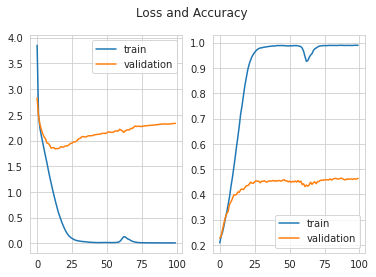

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train','validation'])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train','validation'])

In [ ]:
hin_vocab = vector_hin.get_vocabulary()
hin_index_lookup = dict(zip(range(len(hin_vocab)), hin_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = vector_eng([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vector_hin([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = hin_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_hin_texts = [pair[1] for pair in test_pairs]
blue1=[]
blue2=[]
blue3=[]
blue4=[]
for i in range(100):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("hindi : ",test_hin_texts[i])
    print("predicted: ",translated)
    print('Cumulative 1-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_fra_texts[i], translated, weights=(1, 0, 0, 0))))
    print('Cumulative 2-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.5, 0.5, 0, 0))))
    print('Cumulative 3-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))))
    print('Cumulative 4-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_fra_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))))
    bluescore1=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1, 0, 0, 0))
    blue1.append(bluescore1)

    bluescore2=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.5, 0.5, 0, 0))
    blue2.append(bluescore2)

    bluescore3=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))
    blue3.append(bluescore3)

    bluescore4=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
    blue4.append(bluescore4)    
    print("____________________________________________________________________________") 

1
english:  I'm very thirsty.
hindi :  [start] मुझे बहुत प्यास लगी है। [end]
predicted:  [start] मैं बहुत व्यस्त हूँ। [end]
Cumulative 1-gram BLEU score: 0.5882
Cumulative 2-gram BLEU score: 0.7670
Cumulative 3-gram BLEU score: 0.8394
Cumulative 4-gram BLEU score: 0.8758
____________________________________________________________________________
2
english:  The water pipe burst.
hindi :  [start] पानी का पाइप फट गया। [end]
predicted:  [start] पानी पिया नहीं जा सकता है। [end]
Cumulative 1-gram BLEU score: 0.4250
Cumulative 2-gram BLEU score: 0.6519
Cumulative 3-gram BLEU score: 0.7540
Cumulative 4-gram BLEU score: 0.8074
____________________________________________________________________________
3
english:  He's my husband.
hindi :  [start] यह मेरा पति है। [end]
predicted:  [start] उसकी अपने पहले पति से भी होती है। [end]
Cumulative 1-gram BLEU score: 0.3617
Cumulative 2-gram BLEU score: 0.6014
Cumulative 3-gram BLEU score: 0.7149
Cumulative 4-gram BLEU score: 0.7755
___________________

In [ ]:
input_sentence = ['hi']
translated = decode_sequence(input_sentence)
print("predicted: ",translated)

predicted:  [start] अद्भुत [end]


In [ ]:
print(blue1),print(blue2),print(blue3),print(blue4)

[0.5882352941176471, 0.425, 0.3617021276595745, 0.5471698113207547, 0.6511627906976745, 0.6285714285714286, 0.42857142857142855, 0.4827586206896552, 0.5, 0.4166666666666667, 0.4375, 0.5333333333333333, 0.6296296296296297, 0.5106382978723404, 0.47619047619047616, 0.5283018867924528, 0.5227272727272727, 0.6904761904761905, 0.45714285714285713, 0.6, 0.5277777777777778, 0.525, 0.5, 0.4444444444444444, 0.5227272727272727, 0.5714285714285714, 0.48717948717948717, 0.5333333333333333, 0.5, 0.5675675675675675, 0.5434782608695652, 0.5333333333333333, 0.5945945945945946, 0.37209302325581395, 0.631578947368421, 0.4583333333333333, 0.7307692307692307, 0.5098039215686274, 0.41304347826086957, 0.5227272727272727, 0.46, 0.40476190476190477, 0.44680851063829785, 0.4838709677419355, 0.5098039215686274, 0.48, 0.3421052631578948, 0.5, 0.5740740740740741, 0.5476190476190477, 0.47058823529411764, 0.4888888888888889, 0.42857142857142855, 0.5238095238095238, 0.5238095238095238, 0.5945945945945946, 0.435897435

(None, None, None, None)

In [ ]:
total_blue=[]
total_blue.append(sum(blue1)/len(blue1))
total_blue.append(sum(blue2)/len(blue2)) 
total_blue.append(sum(blue3)/len(blue3))  
total_blue.append(sum(blue4)/len(blue4))

In [ ]:
print(total_blue)

[0.5178109279057965, 0.71734078987459, 0.8025503834794803, 0.8462936460002798]


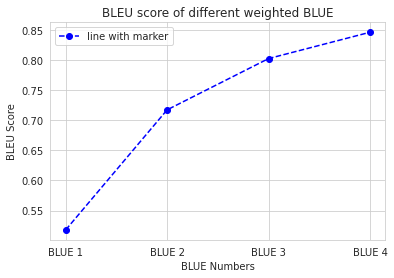

In [ ]:
x = ['BLUE 1', 'BLUE 2', 'BLUE 3', 'BLUE 4']
y = np.array(total_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score of different weighted BLUE")
plt.xlabel("BLUE Numbers")
plt.ylabel("BLEU Score")
plt.plot(x, y, linestyle='--', marker='o', color='b', label='line with marker')
plt.legend()
plt.show()

In [ ]:
!unzip /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/eng-hin.zip

Archive:  /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/eng-hin.zip
  inflating: content/drive/MyDrive/NeuralMachineTranslation/models/eng-hin.h5  


In [ ]:
transformer=tf.keras.models.load_model("/content/content/drive/MyDrive/NeuralMachineTranslation/models/eng-hin.h5",custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder': TransformerEncoder, 'TransformerDecoder': TransformerDecoder})

In [ ]:
pip install jiwer

     |████████████████████████████████| 50 kB 7.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149861 sha256=32c285d4dc1196fe94bc42bf59c6cb83f99e7e211fa14a91caffed3ce1ed01b0
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
import jiwer
test_eng_texts = [pair[0] for pair in test_pairs]
test_hin_texts = [pair[1] for pair in test_pairs]
werlist=[]
for i in range(100):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("german : ",test_hin_texts[i])
    print("predicted: ",translated)
    werscore = jiwer.wer((test_hin_texts[i]), translated)
    print("wer:", werscore)
    werlist.append(werscore)    
    print("____________________________________________________________________________") 

1
english:  You keep a dog, don't you?
german :  [start] तुम्हारे पास एक कुत्ता है, है न? [end]
predicted:  [start] तुम्हारे पास एक कुत्ता है है न [end]
wer: 0.2222222222222222
____________________________________________________________________________
2
english:  I am at home.
german :  [start] मैं घर पर हूँ। [end]
predicted:  [start] मैं घर पर हूँ। [end]
wer: 0.0
____________________________________________________________________________
3
english:  Leave your umbrella at the front door.
german :  [start] अपने छाते को सामने वाले द्वार छोड़ दो। [end]
predicted:  [start] अपने छाते को सामने वाले द्वार छोड़ दो। [end]
wer: 0.0
____________________________________________________________________________
4
english:  Tom handed the list to Mary.
german :  [start] टॉम ने मैरी को सूची सौंपी। [end]
predicted:  [start] टॉम ने मैरी को सूची देदी। [end]
wer: 0.125
____________________________________________________________________________
5
english:  He set fire to his own house.
german :  [star

In [ ]:
werlist

[0.2222222222222222,
 0.0,
 0.0,
 0.125,
 0.0,
 0.0,
 0.125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.15384615384615385,
 0.375,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.14285714285714285,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.14285714285714285,
 0.0,
 0.0,
 0.0,
 0.125,
 0.0,
 0.0,
 0.7272727272727273,
 0.0,
 0.1111111111111111,
 0.0,
 0.0,
 0.0,
 0.14285714285714285,
 0.0,
 0.0,
 0.07692307692307693,
 0.0,
 0.0,
 0.0,
 1.1,
 0.18181818181818182,
 0.0,
 0.7142857142857143,
 0.0,
 0.0,
 0.0,
 0.6,
 0.1,
 0.3333333333333333,
 0.1,
 0.125,
 0.0,
 0.0,
 0.0,
 0.16666666666666666,
 0.0,
 0.6,
 0.5714285714285714,
 0.125,
 0.0,
 0.0,
 0.0,
 0.14285714285714285,
 0.0,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4,
 0.625,
 0.125,
 0.0,
 0.1111111111111111,
 0.7272727272727273,
 0.125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
print(sum(werlist)/len(werlist))

0.09868720168720166


In [ ]:
 !pip install -U nltk

     |████████████████████████████████| 1.5 MB 32.5 MB/s 
     |████████████████████████████████| 749 kB 59.1 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
from nltk.translate.meteor_score import single_meteor_score
test_eng_texts = [pair[0] for pair in test_pairs]
test_hin_texts = [pair[1] for pair in test_pairs]
metlist=[]
for i in range(100):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("german : ",test_hin_texts[i])
    print("predicted: ",translated)
    metscore = single_meteor_score(word_tokenize(test_hin_texts[i]), word_tokenize(translated))
    print("meteor score:", metscore)
    metlist.append(metscore)    
    print("____________________________________________________________________________") 

1
english:  You keep a dog, don't you?
german :  [start] तुम्हारे पास एक कुत्ता है, है न? [end]
predicted:  [start] तुम्हारे पास एक कुत्ता है है न [end]
meteor score: 0.8729809691348154
____________________________________________________________________________
2
english:  I am at home.
german :  [start] मैं घर पर हूँ। [end]
predicted:  [start] मैं घर पर हूँ। [end]
meteor score: 0.9995
____________________________________________________________________________
3
english:  Leave your umbrella at the front door.
german :  [start] अपने छाते को सामने वाले द्वार छोड़ दो। [end]
predicted:  [start] अपने छाते को सामने वाले द्वार छोड़ दो। [end]
meteor score: 0.9998177842565598
____________________________________________________________________________
4
english:  Tom handed the list to Mary.
german :  [start] टॉम ने मैरी को सूची सौंपी। [end]
predicted:  [start] टॉम ने मैरी को सूची देदी। [end]
meteor score: 0.9139118457300276
___________________________________________________________________

In [ ]:
metlist

[0.8729809691348154,
 0.9995,
 0.9998177842565598,
 0.9139118457300276,
 0.9998177842565598,
 0.9997724169321802,
 0.9280792420327304,
 0.9997724169321802,
 0.9996243425995492,
 0.9997106481481481,
 0.999898229187869,
 0.9997106481481481,
 0.9998177842565598,
 0.9997724169321802,
 0.9995,
 0.9996243425995492,
 0.8909086941340781,
 0.7585268884703913,
 0.9997106481481481,
 0.9995,
 0.9382276400493084,
 0.9997724169321802,
 0.9996243425995492,
 0.9054545454545455,
 0.9997724169321802,
 0.9997724169321802,
 0.9996243425995492,
 0.9995,
 0.9999375,
 0.9054545454545455,
 0.9990234375,
 0.9997106481481481,
 0.9999142661179699,
 0.9139118457300276,
 0.9996243425995492,
 0.9993141289437586,
 0.548559670781893,
 0.9985422740524781,
 0.920940170940171,
 0.9997106481481481,
 0.9997724169321802,
 0.9996243425995492,
 0.9215917772067505,
 0.9996243425995492,
 0.9997724169321802,
 0.9489474396396744,
 0.9999530428249437,
 0.999898229187869,
 0.9999375,
 0.4118104118104117,
 0.8761712232062635,
 0.99

In [ ]:
print(sum(metlist)/len(metlist))

0.9381348132598126


In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_hin_texts = [pair[1] for pair in test_pairs]
len_blue=[]
b4l3,b4l4,b4l5,b4l6,b4l7,b4l8,b4l9,b4l10,b4l11,b4l12,b4l13,b4l14,b4l15,b4l16,b4l17,b4l18,b4l19,b4l20 = ([], ) * 18

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==3):
        b3=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l3.append(b3)

In [ ]:
b4l3

[0.9457416090031758]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==4):
        b4=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l4.append(b4)

In [ ]:
b4l4

[0.9457416090031758, 0.9245812102055234, 0.94149097734812]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==5):
        b5=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l5.append(b5)

In [ ]:
b4l5

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==6):
        b6=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l6.append(b6)

In [ ]:
b4l6

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==7):
        b7=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l7.append(b7)

In [ ]:
b4l7

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==8):
        b8=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l8.append(b8)

In [ ]:
b4l8

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==9):
        b9=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l9.append(b9)

In [ ]:
b4l9

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==10):
        b10=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l10.append(b10)

In [ ]:
b4l10

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==11):
        b11=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l11.append(b11)

In [ ]:
b4l11

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==12):
        b12=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l12.append(b12)

In [ ]:
b4l12

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==13):
        b13=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l13.append(b13)

In [ ]:
b4l13

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==14):
        b14=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l14.append(b14)

In [ ]:
b4l14

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==15):
        b15=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l15.append(b15)

In [ ]:
b4l15

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==16):
        b16=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l16.append(b16)

In [ ]:
b4l16

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==17):
        b17=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l17.append(b17)

In [ ]:
b4l17

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==18):
        b18=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l18.append(b18)

In [ ]:
b4l18

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==19):
        b19=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l19.append(b19)

In [ ]:
b4l19

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==20):
        b20=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l20.append(b20)

In [ ]:
b4l20

[0.9457416090031758,
 0.9245812102055234,
 0.94149097734812,
 0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185,
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448,
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304,
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,

In [ ]:
blu4l3=[0.9457416090031758]
blu4l4=[0.9245812102055234, 0.94149097734812]
blu4l5=[0.9174014451319407,
 0.8739351325046805,
 0.9245812102055234,
 0.8739351325046805,
 0.8545740127924681,
 0.9036020036098448,
 0.9193227152249185]
 
blu4l6=[
 0.9193227152249185,
 0.9166068134248218,
 0.9064126192070304,
 0.9242522362305915,
 0.9090620828861675,
 0.89968172894662,
 0.9036020036098448]

blu4l7=[
 0.8891397050194614,
 0.9036020036098448,
 0.8801117367933934,
 0.912167909070388,
 0.9006148486749553,
 0.8694417438899827,
 0.9099882808096075,
 0.9066393640951106,
 0.8947853200770762,
 0.9094889729229877,
 0.7796914510717229,
 0.9003574197938159,
 0.9006148486749553,
 0.8746954073710493,
 0.9064126192070304]

blu4l8=[
 0.8857000285382948,
 0.8959759884726188,
 0.8707970741827025,
 0.8882997043605481,
 0.8954237688029468,
 0.8707970741827025,
 0.8746954073710493,
 0.8801117367933934,
 0.9066393640951106,
 0.831173435395861,
 0.8857000285382948,
 0.878360261971396,
 0.9139305605923006,
 0.8801117367933934,
 0.8979007600118484,
 0.8891397050194614,
 0.8904071917791836,
 0.8954237688029468,
 0.9008344305146696,
 0.9094889729229877,
 0.9128709291752768]

blu4l9=[
 0.8593887047640296,
 0.8540052444156726,
 0.8873560657375263,
 0.8986505734084012,
 0.8901717899894724,
 0.8715242540014305,
 0.9146912192286945,
 0.8816357455079741,
 0.9062173768436956,
 0.8786978981136877,
 0.8739351325046805,
 0.8560538001743465,
 0.8641689613760013,
 0.8682041012598415,
 0.8986505734084012,
 0.8891397050194614,
 0.860789505997226,
 0.8488678884979053,
 0.8732083666932099,
 0.8836678162313202]

blu4l10=[
 0.8641689613760013,
 0.8983020565410774,
 0.8862883384133153,
 0.871846861591009,
 0.8964583444957605,
 0.8814923084666203,
 0.8572321289096398,
 0.8881501211769413,
 0.8785470875189102,
 0.8513877958924954]

blu4l11=[
 0.8271441560745232,
 0.8773826753016616,
 0.8715242540014305]

blu4l12=[0.8640468087174444]

blu4l13=[
 0.85043551823732,
 0.85043551823732,
 0.8445605386932062,
 0.8599476570625982,
 0.7624971473610974,
 0.8557327598778156,
 0.8439267217074713,
 0.8375394763306394]

blu4l14=[
 0.8158498504552436,
 0.8438418068075982]
 
blu4l15=[0]

blu4l16=[
 0.8158498504552436,
 0.8438418068075982,
 0.8128788730771674,
 0.802906203251852]

blu4l17=[0]

blu4l18=[
 0.7922410709252884]

blu4l19=[0]
blu4l20=[0]

In [ ]:
len_blue.append(sum(blu4l3)/len(blu4l3))
len_blue.append(sum(blu4l4)/len(blu4l4))
len_blue.append(sum(blu4l5)/len(blu4l5))
len_blue.append(sum(blu4l6)/len(blu4l6))
len_blue.append(sum(blu4l7)/len(blu4l7))
len_blue.append(sum(blu4l8)/len(blu4l8))
len_blue.append(sum(blu4l9)/len(blu4l9))
len_blue.append(sum(blu4l10)/len(blu4l10))
len_blue.append(sum(blu4l11)/len(blu4l11))
len_blue.append(sum(blu4l12)/len(blu4l12))
len_blue.append(sum(blu4l13)/len(blu4l13))
len_blue.append(sum(blu4l14)/len(blu4l14))
len_blue.append(sum(blu4l15)/len(blu4l15))
len_blue.append(sum(blu4l16)/len(blu4l16))
len_blue.append(sum(blu4l17)/len(blu4l17))
len_blue.append(sum(blu4l18)/len(blu4l18))
len_blue.append(sum(blu4l19)/len(blu4l19))
len_blue.append(sum(blu4l20)/len(blu4l20))

In [ ]:
len_blue

[0.9457416090031758,
 0.9330360937768217,
 0.8953359502820081,
 0.9112771713614277,
 0.8891834420720921,
 0.8882753299198566,
 0.8779512361586489,
 0.8773874004381771,
 0.8586836951258717,
 0.8640468087174444,
 0.8381344171884335,
 0.829845828631421,
 0.0,
 0.8188691833979653,
 0.0,
 0.7922410709252884,
 0.0,
 0.0]

In [ ]:
len_blue=[0.9457416090031758,
 0.9330360937768217,
 0.8953359502820081,
 0.9112771713614277,
 0.8891834420720921,
 0.8882753299198566,
 0.8779512361586489,
 0.8773874004381771,
 0.8586836951258717,
 0.8640468087174444,
 0.8381344171884335,
 0.829845828631421,
 0.822518616516161,
 0.8188691833979653,
 0.806165161163516,
 0.7922410709252884,
 0.7892168185616351,
 0.78547135158616]

In [ ]:
len(len_blue)

18

In [ ]:
len([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

18

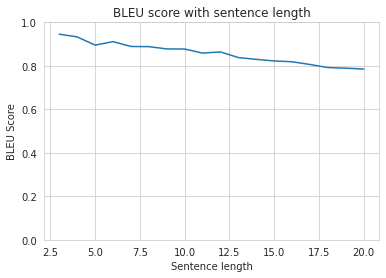

In [ ]:
x = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
y = np.array(len_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score with sentence length")
plt.xlabel("Sentence length")
plt.ylabel("BLEU Score")
plt.ylim(0,1)
plt.plot(x, y)
plt.show()

In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_hin_texts = [pair[1] for pair in test_pairs]
len_blue=[]
b1l3,b1l4,b1l5,b1l6,b1l7,b1l8,b1l9,b1l10,b1l11,b1l12,b1l13,b1l14,b1l15,b1l16,b1l17,b1l18,b1l19,b1l20 = ([], ) * 18

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==3):
        b3=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l3.append(b3)

In [ ]:
b1l3

[]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==4):
        b4=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l4.append(b4)

In [ ]:
b1l4

[0.7142857142857143, 0.7391304347826086]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==5):
        b5=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l5.append(b5)

In [ ]:
b1l5

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==6):
        b6=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l6.append(b6)

In [ ]:
b1l6

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==7):
        b7=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l7.append(b7)

In [ ]:
b1l7

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==8):
        b8=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l8.append(b8)

In [ ]:
b1l8

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764]

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==9):
        b9=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l9.append(b9)

In [ ]:
b1l9

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764,
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==10):
        b10=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l10.append(b10)

In [ ]:
b1l10

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764,
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==11):
        b11=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l11.append(b11)

In [ ]:
b1l11

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764,
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==12):
        b12=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l12.append(b12)

In [ ]:
b1l12

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764,
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==13):
        b13=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l13.append(b13)

In [ ]:
b1l13

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764,
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==14):
        b14=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l14.append(b14)

In [ ]:
b1l14

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764,
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==15):
        b15=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l15.append(b15)

In [ ]:
b1l15

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764,
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==16):
        b16=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l16.append(b16)

In [ ]:
b1l16

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764,
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==17):
        b17=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l17.append(b17)

In [ ]:
b1l17

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764,
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==18):
        b18=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l18.append(b18)

In [ ]:
b1l18

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764,
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==19):
        b19=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l19.append(b19)

In [ ]:
b1l19

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764,
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.

In [ ]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==20):
        b20=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1,0,0,0))
        b1l20.append(b20)

In [ ]:
b1l20

[0.7142857142857143,
 0.7391304347826086,
 0.7333333333333333,
 0.5217391304347826,
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7,
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737,
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764,
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.

In [ ]:
blu4l3=[0]
blu4l4=[0.7142857142857143, 0.7391304347826086]

blu4l5=[ 0.7333333333333333,
 0.5217391304347826]

blu4l6=[
 0.7333333333333333,
 0.6896551724137931,
 0.71875,
 0.7222222222222222,
 0.7272727272727273,
 0.7333333333333333,
 0.5833333333333334,
 0.7058823529411765,
 0.71875,
 0.6216216216216216,
 0.6666666666666666,
 0.5882352941176471,
 0.6666666666666666,
 0.7096774193548387,
 0.7]

blu4l7=[
 0.6216216216216216,
 0.6829268292682927,
 0.6,
 0.6666666666666666,
 0.6153846153846154,
 0.6829268292682927,
 0.6666666666666666,
 0.6388888888888888,
 0.6486486486486487,
 0.6363636363636364,
 0.7428571428571429,
 0.6060606060606061,
 0.7297297297297297,
 0.5714285714285714,
 0.6511627906976745,
 0.7105263157894737]

blu4l8=[
 0.47619047619047616,
 0.6341463414634146,
 0.6829268292682927,
 0.6222222222222222,
 0.6875,
 0.6578947368421053,
 0.5625,
 0.4523809523809524,
 0.6216216216216216,
 0.47058823529411764]

blu4l9=[
 0.6444444444444445,
 0.6956521739130435,
 0.5909090909090909,
 0.6666666666666666,
 0.5471698113207547,
 0.5714285714285714,
 0.5111111111111111,
 0.5882352941176471,
 0.6744186046511628,
 0.6086956521739131,
 0.6585365853658537,
 0.6,
 0.6274509803921569,
 0.43902439024390244,
 0.5576923076923077,
 0.6041666666666666,
 0.6326530612244898,
 0.6136363636363636]

blu4l10=[
 0.5833333333333334,
 0.5925925925925926,
 0.6037735849056604,
 0.5,
 0.5652173913043478,
 0.52,
 0.6078431372549019,
 0.5652173913043478,
 0.5686274509803921,
 0.6739130434782609,
 0.5813953488372093]

blu4l11=[
 0.3898305084745763,
 0.5862068965517241,
 0.5849056603773585,
 0.5818181818181818,
 0.625,
 0.5652173913043478,
 0.6037735849056604,
 0.5471698113207547,
 0.4262295081967213]

blu4l12=[
 0.47368421052631576,
 0.5,
 0.5862068965517241,
 0.5757575757575758]

blu4l13=[
 0.5254237288135594,
 0.4696969696969697,
 0.49295774647887325,
 0.4594594594594595]

blu4l14=[
 0.5070422535211268,
 0.47761194029850745]

blu4l15=[
 0.4492753623188406,
 0.4657534246575342]

blu4l16=[
 0.41304347826086957,
 0.44871794871794873]

blu4l17=[0]

blu4l18=[ 0.3939393939393939,
 0.47297297297297297]

blu4l19=[ 0.4]
blu4l20=[0]

In [ ]:
len_blue.append(sum(blu4l3)/len(blu4l3))
len_blue.append(sum(blu4l4)/len(blu4l4))
len_blue.append(sum(blu4l5)/len(blu4l5))
len_blue.append(sum(blu4l6)/len(blu4l6))
len_blue.append(sum(blu4l7)/len(blu4l7))
len_blue.append(sum(blu4l8)/len(blu4l8))
len_blue.append(sum(blu4l9)/len(blu4l9))
len_blue.append(sum(blu4l10)/len(blu4l10))
len_blue.append(sum(blu4l11)/len(blu4l11))
len_blue.append(sum(blu4l12)/len(blu4l12))
len_blue.append(sum(blu4l13)/len(blu4l13))
len_blue.append(sum(blu4l14)/len(blu4l14))
len_blue.append(sum(blu4l15)/len(blu4l15))
len_blue.append(sum(blu4l16)/len(blu4l16))
len_blue.append(sum(blu4l17)/len(blu4l17))
len_blue.append(sum(blu4l18)/len(blu4l18))
len_blue.append(sum(blu4l19)/len(blu4l19))
len_blue.append(sum(blu4l20)/len(blu4l20))

In [ ]:
len_blue

[0.0,
 0.7267080745341614,
 0.6275362318840579,
 0.6856933428851573,
 0.6544912224587831,
 0.5867971415283203,
 0.6017717653310082,
 0.5783557521810042,
 0.545572393661036,
 0.5339121707089038,
 0.48688447611221547,
 0.49232709690981713,
 0.4575143934881874,
 0.43088071348940915,
 0.0,
 0.4334561834561834,
 0.4,
 0.0]

In [ ]:
len_blue=[0.726186113163,
 0.7267080745341614,
 0.6275362318840579,
 0.6856933428851573,
 0.6544912224587831,
 0.5867971415283203,
 0.6017717653310082,
 0.5783557521810042,
 0.545572393661036,
 0.5339121707089038,
 0.48688447611221547,
 0.49232709690981713,
 0.4575143934881874,
 0.43088071348940915,
 0.43468648315316866,
 0.4334561834561834,
 0.4,
 0.4036168948943613]

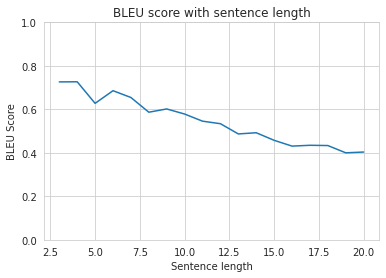

In [ ]:
x = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
y = np.array(len_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score with sentence length")
plt.xlabel("Sentence length")
plt.ylabel("BLEU Score")
plt.ylim(0,1)
plt.plot(x, y)
plt.show()

In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, hin = line.split("\t")[:2]
    eng = "[start] " + eng + " [end]"
    text_pairs.append((eng, hin))
  
print(text_pairs[1])

('[start] Duck! [end]', 'झुको!')


In [ ]:
for i in range(5):
    print(text_pairs[i])

('[start] Wow! [end]', 'वाह!')
('[start] Duck! [end]', 'झुको!')
('[start] Duck! [end]', 'बतख़!')
('[start] Help! [end]', 'बचाओ!')
('[start] Jump. [end]', 'उछलो.')


In [ ]:
random.shuffle(text_pairs)
# num_val_samples = int(0.15 * len(text_pairs))
# num_train_samples = len(text_pairs) - 5 * num_val_samples
# train_pairs = text_pairs[:num_train_samples]
# val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
# test_pairs = text_pairs[num_train_samples + num_val_samples : 100694]
train_pairs = text_pairs[:2500]
val_pairs = text_pairs[2500 : 2834]
test_pairs = text_pairs[2834 : 2934]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

2934 total pairs
2500 training pairs
334 validation pairs
100 test pairs


In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/input_eng.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/output_eng.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_eng = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_eng = TextVectorization.from_config(pickle_obj_eng["config"])
vector_eng.set_vocabulary(pickle_obj_eng["vocabulary"])
vector_eng.set_weights(pickle_obj_eng["weights"])

# NOW "vector" can be used in same way

In [ ]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/output_hin.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/input_hin.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_hin = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_hin = TextVectorization.from_config(pickle_obj_hin["config"])
vector_hin.set_vocabulary(pickle_obj_hin["vocabulary"])
vector_hin.set_weights(pickle_obj_hin["weights"])

# NOW "vector" can be used in same way

In [ ]:
def format_dataset(eng, hin):
    eng = vector_eng(eng)
    hin = vector_hin(hin)
    return ({"encoder_inputs": hin, "decoder_inputs": eng[:, :-1],}, eng[:, 1:])

vocab_size = 100000
sequence_length = 20
batch_size = 128

def make_dataset(pairs):
    eng_texts, hin_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    hin_texts = list(hin_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, hin_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [ ]:
embed_dim = 256
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   25605120    ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   2630144     ['positional_embedding[

In [ ]:
epochs = 100  # This should be at least 30 for convergence

transformer.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
20/20 [==============================] - 15s 407ms/step - loss: 3.7007 - accuracy: 0.1906 - val_loss: 2.5190 - val_accuracy: 0.2316
Epoch 2/100
20/20 [==============================] - 8s 378ms/step - loss: 2.2468 - accuracy: 0.2577 - val_loss: 2.1129 - val_accuracy: 0.2618
Epoch 3/100
20/20 [==============================] - 8s 388ms/step - loss: 1.9969 - accuracy: 0.2796 - val_loss: 1.9688 - val_accuracy: 0.3034
Epoch 4/100
20/20 [==============================] - 8s 387ms/step - loss: 1.8574 - accuracy: 0.3148 - val_loss: 1.8960 - val_accuracy: 0.3321
Epoch 5/100
20/20 [==============================] - 8s 384ms/step - loss: 1.7287 - accuracy: 0.3432 - val_loss: 1.8184 - val_accuracy: 0.3454
Epoch 6/100
20/20 [==============================] - 8s 387ms/step - loss: 1.6138 - accuracy: 0.3640 - val_loss: 1.7531 - val_accuracy: 0.3616
Epoch 7/100
20/20 [==============================] - 8s 391ms/step - loss: 1.5193 - accuracy: 0.3854 - val_loss: 1.7241 - val_accuracy: 0.376

In [ ]:
transformer.save('/content/drive/MyDrive/neural machine translation/models/hin-eng.h5')

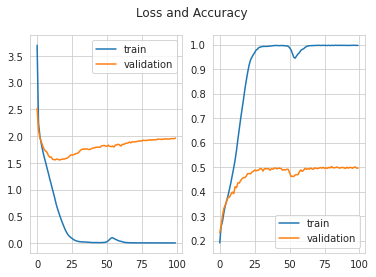

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train','validation'])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train','validation'])

In [ ]:
eng_vocab = vector_eng.get_vocabulary()
eng_index_lookup = dict(zip(range(len(eng_vocab)), eng_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = vector_hin([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vector_eng([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = eng_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [ ]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_hin_texts = [pair[1] for pair in test_pairs]
blue1=[]
blue2=[]
blue3=[]
blue4=[]
for i in range(100):
    input_sentence = test_hin_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("hindi: ",test_hin_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    print('Cumulative 1-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(1, 0, 0, 0))))
    print('Cumulative 2-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.5, 0.5, 0, 0))))
    print('Cumulative 3-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))))
    print('Cumulative 4-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))))
    bluescore1=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(1, 0, 0, 0))
    blue1.append(bluescore1)

    bluescore2=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.5, 0.5, 0, 0))
    blue2.append(bluescore2)

    bluescore3=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))
    blue3.append(bluescore3)

    bluescore4=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
    blue4.append(bluescore4)    
    print("____________________________________________________________________________") 

1
hindi:  मुझे ट्राए करने दो।
english :  [start] Let me try it. [end]
predicted:  [start] let me try to do [end]
Cumulative 1-gram BLEU score: 0.4000
Cumulative 2-gram BLEU score: 0.6325
Cumulative 3-gram BLEU score: 0.7391
Cumulative 4-gram BLEU score: 0.7953
____________________________________________________________________________
2
hindi:  मेरे पास तुमसे मिलने के लिए समय नहीं है।
english :  [start] I have no time to see you. [end]
predicted:  [start] i have no money for you [end]
Cumulative 1-gram BLEU score: 0.4595
Cumulative 2-gram BLEU score: 0.6778
Cumulative 3-gram BLEU score: 0.7736
Cumulative 4-gram BLEU score: 0.8233
____________________________________________________________________________
3
hindi:  मैंने किसी को पीछे से मेरे नाम पुकारते हुए सुना।
english :  [start] I heard someone call my name from behind. [end]
predicted:  [start] i bought an old friend of my name [end]
Cumulative 1-gram BLEU score: 0.3830
Cumulative 2-gram BLEU score: 0.6189
Cumulative 3-gram BLEU s

In [ ]:
total_blue=[]
total_blue.append(sum(blue1)/len(blue1))
total_blue.append(sum(blue2)/len(blue2)) 
total_blue.append(sum(blue3)/len(blue3))  
total_blue.append(sum(blue4)/len(blue4))

In [ ]:
print(total_blue)

[0.3693922000272153, 0.6054959889293027, 0.7175093752078863, 0.7774064139081183]


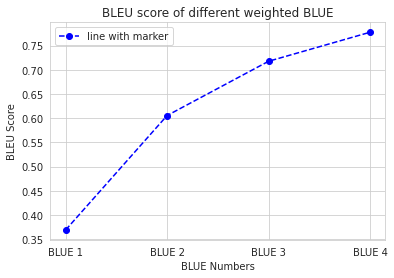

In [ ]:
x = ['BLUE 1', 'BLUE 2', 'BLUE 3', 'BLUE 4']
y = np.array(total_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score of different weighted BLUE")
plt.xlabel("BLUE Numbers")
plt.ylabel("BLEU Score")
plt.plot(x, y, linestyle='--', marker='o', color='b', label='line with marker')
plt.legend()
plt.show()

In [ ]:
!unzip 

In [ ]:
transformer=tf.keras.models.load_model("/content/drive/MyDrive/NeuralMachineTranslation/models/hin-eng.h5",custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder': TransformerEncoder, 'TransformerDecoder': TransformerDecoder})

In [ ]:
!pip install jiwer
import jiwer
test_eng_texts = [pair[0] for pair in test_pairs]
test_hin_texts = [pair[1] for pair in test_pairs]
werlist=[]
for i in range(100):
    input_sentence = test_hin_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("german: ",test_hin_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    werscore = jiwer.wer(test_eng_texts[i], translated)
    print("wer:", werscore)
    werlist.append(werscore)    
    print("____________________________________________________________________________") 

     |████████████████████████████████| 50 kB 5.4 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149865 sha256=2d17d7b9d5c7cdced7c7d7967147a379f7c08945f60e2048dec28d564a163e16
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein
1
german:  वह मेरा चचेरा भाई नहीं है।
english :  [start] He isn't my cousin. [end]
predicted:  [start] he isnt my cousin [end]
wer: 0.5
____________________________________________________________________________
2
german:  ध्यान से चुने।
english :  [start] Choose carefully. [end]
predicted:  [start] choose carefully [end]
wer: 0.5
____________________________________________________________________________
3
german:  मैं सोच रहा हूँ कि नौकरी लूँ या नहीं लूँ।
english :  [start] I'm wondering whether to take on that job. [end]
predicted:  [start] im wondering whether to take on that job [end]
wer: 0.2
____

In [ ]:
werlist

[0.5,
 0.5,
 0.2,
 0.2857142857142857,
 0.3333333333333333,
 0.21428571428571427,
 0.2222222222222222,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.16666666666666666,
 0.2,
 0.25,
 0.42857142857142855,
 0.5,
 0.25,
 0.3,
 0.25,
 0.8,
 0.3333333333333333,
 0.2857142857142857,
 0.3333333333333333,
 0.2857142857142857,
 0.3333333333333333,
 0.2222222222222222,
 0.2222222222222222,
 0.3333333333333333,
 0.18181818181818182,
 0.8181818181818182,
 0.2,
 0.7777777777777778,
 0.2,
 1.0,
 0.46153846153846156,
 0.2222222222222222,
 0.375,
 0.375,
 0.25,
 0.2,
 0.3333333333333333,
 0.5,
 0.2857142857142857,
 0.3333333333333333,
 0.3333333333333333,
 0.5,
 0.18181818181818182,
 0.15384615384615385,
 0.25,
 0.25,
 0.4,
 0.25,
 0.5555555555555556,
 0.375,
 0.375,
 0.16666666666666666,
 0.42857142857142855,
 0.6,
 0.7857142857142857,
 0.3333333333333333,
 0.7272727272727273,
 0.25,
 0.5,
 0.2222222222222222,
 0.16666666666666666,
 0.3333333333333333,
 0.75,
 0.375,
 0.2,
 0.66666

In [ ]:
print(sum(werlist)/len(werlist))

0.3634154734154733


In [ ]:
!pip install -U nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')

     |████████████████████████████████| 1.5 MB 23.8 MB/s 
     |████████████████████████████████| 749 kB 40.3 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.translate.meteor_score import single_meteor_score
test_eng_texts = [pair[0] for pair in test_pairs]
test_hin_texts = [pair[1] for pair in test_pairs]
metlist=[]
for i in range(100):
    input_sentence = test_hin_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("hindi: ",test_hin_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    metscore = single_meteor_score(word_tokenize(test_eng_texts[i]), word_tokenize(translated))
    print("meteor score:", metscore)
    metlist.append(metscore)    
    print("____________________________________________________________________________") 

1
hindi:  वह मेरा चचेरा भाई नहीं है।
english :  [start] He isn't my cousin. [end]
predicted:  [start] he isnt my cousin [end]
meteor score: 0.7485875706214691
____________________________________________________________________________
2
hindi:  ध्यान से चुने।
english :  [start] Choose carefully. [end]
predicted:  [start] choose carefully [end]
meteor score: 0.8918539325842695
____________________________________________________________________________
3
hindi:  मैं सोच रहा हूँ कि नौकरी लूँ या नहीं लूँ।
english :  [start] I'm wondering whether to take on that job. [end]
predicted:  [start] im wondering whether to take on that job [end]
meteor score: 0.8177290090629916
____________________________________________________________________________
4
hindi:  वह भारत गया हुआ है।
english :  [start] He has been to India. [end]
predicted:  [start] he has been to india [end]
meteor score: 0.9215917772067505
____________________________________________________________________________
5
hindi:  मै

In [ ]:
metlist

[0.7485875706214691,
 0.8918539325842695,
 0.8177290090629916,
 0.9215917772067505,
 0.8044763513513514,
 0.9069865319865321,
 0.9335490187731471,
 0.9137614678899082,
 0.8211575489862951,
 0.9137614678899082,
 0.9458210059171597,
 0.9382276400493084,
 0.9458210059171597,
 0.7707031250000002,
 0.7145928899082569,
 0.9280792420327304,
 0.8817166106949108,
 0.9458210059171597,
 0.5402650356778795,
 0.9137614678899082,
 0.9215917772067505,
 0.9137614678899082,
 0.9215917772067505,
 0.9137614678899082,
 0.9335490187731471,
 0.9335490187731471,
 0.9137614678899082,
 0.9422781271837876,
 0.4218516674962668,
 0.9382276400493084,
 0.48728186926944694,
 0.9382276400493084,
 0.7017173423423423,
 0.6651536312849161,
 0.9335490187731471,
 0.7303086523865745,
 0.9280792420327304,
 0.9280792420327304,
 0.9382276400493084,
 0.9137614678899082,
 0.755560651226783,
 0.9215917772067505,
 0.9137614678899082,
 0.9137614678899082,
 0.7282110091743119,
 0.9422781271837876,
 0.9489474396396744,
 0.7890166487

In [ ]:
print(sum(metlist)/len(metlist))

0.8473180157201753


# ENGLISH TO HINDI FOR COMPARISON

In [9]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, hin = line.split("\t")[:2]
    hin = "[start] " + hin + " [end]"
    text_pairs.append((eng, hin))
  
print(text_pairs[1])

('Duck!', '[start] झुको! [end]')


In [10]:
for i in range(5):
    print(text_pairs[i])

('Wow!', '[start] वाह! [end]')
('Duck!', '[start] झुको! [end]')
('Duck!', '[start] बतख़! [end]')
('Help!', '[start] बचाओ! [end]')
('Jump.', '[start] उछलो. [end]')


In [11]:
random.shuffle(text_pairs)
train_pairs = text_pairs[:2000]
val_pairs = text_pairs[2000 : 2434]
test_pairs = text_pairs[2434 : 2934]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

2934 total pairs
2000 training pairs
434 validation pairs
500 test pairs


In [12]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/input_eng.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/input_eng.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_eng = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_eng = TextVectorization.from_config(pickle_obj_eng["config"])
vector_eng.set_vocabulary(pickle_obj_eng["vocabulary"])
vector_eng.set_weights(pickle_obj_eng["weights"])

# NOW "vector" can be used in same way

In [13]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/output_hin.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NeuralMachineTranslation/VectorObjects/output_hin.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_hin = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_hin = TextVectorization.from_config(pickle_obj_hin["config"])
vector_hin.set_vocabulary(pickle_obj_hin["vocabulary"])
vector_hin.set_weights(pickle_obj_hin["weights"])

# NOW "vector" can be used in same way

In [14]:
def format_dataset(eng, hin):
    eng = vector_eng(eng)
    hin = vector_hin(hin)
    return ({"encoder_inputs": eng, "decoder_inputs": hin[:, :-1],}, hin[:, 1:])

vocab_size = 100000
sequence_length = 20
batch_size = 128

def make_dataset(pairs):
    eng_texts, hin_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    hin_texts = list(hin_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, hin_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [15]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


In [16]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [17]:
embed_dim = 256
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [18]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   25605120    ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   2630144     ['positional_embedding[

In [19]:
epochs = 100  # This should be at least 30 for convergence

transformer.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
16/16 [==============================] - 20s 757ms/step - loss: 4.2326 - accuracy: 0.1395 - val_loss: 3.1631 - val_accuracy: 0.1768
Epoch 2/100
16/16 [==============================] - 11s 664ms/step - loss: 2.6900 - accuracy: 0.2148 - val_loss: 2.6260 - val_accuracy: 0.1805
Epoch 3/100
16/16 [==============================] - 11s 664ms/step - loss: 2.3635 - accuracy: 0.2254 - val_loss: 2.3902 - val_accuracy: 0.2424
Epoch 4/100
16/16 [==============================] - 11s 667ms/step - loss: 2.2006 - accuracy: 0.2497 - val_loss: 2.3043 - val_accuracy: 0.2553
Epoch 5/100
16/16 [==============================] - 11s 667ms/step - loss: 2.1036 - accuracy: 0.2661 - val_loss: 2.2375 - val_accuracy: 0.2729
Epoch 6/100
16/16 [==============================] - 11s 670ms/step - loss: 2.0204 - accuracy: 0.2818 - val_loss: 2.1997 - val_accuracy: 0.2863
Epoch 7/100
16/16 [==============================] - 11s 667ms/step - loss: 1.9141 - accuracy: 0.3055 - val_loss: 2.1405 - val_accuracy:

In [ ]:
transformer.save("/content/drive/MyDrive/eng-hin.h5")

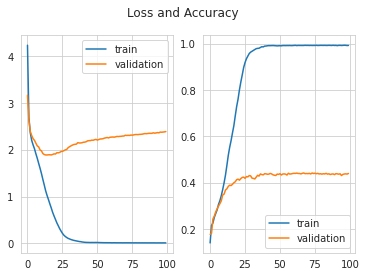

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train','validation'])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train','validation'])

In [22]:
hin_vocab = vector_hin.get_vocabulary()
hin_index_lookup = dict(zip(range(len(hin_vocab)), hin_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = vector_eng([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vector_hin([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = hin_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


In [24]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_hin_texts = [pair[1] for pair in test_pairs]
blue1=[]
blue2=[]
blue3=[]
blue4=[]
for i in range(500):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("hindi : ",test_hin_texts[i])
    print("predicted: ",translated)
    print('Cumulative 1-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1, 0, 0, 0))))
    print('Cumulative 2-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.5, 0.5, 0, 0))))
    print('Cumulative 3-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))))
    print('Cumulative 4-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))))
    bluescore1=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(1, 0, 0, 0))
    blue1.append(bluescore1)

    bluescore2=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.5, 0.5, 0, 0))
    blue2.append(bluescore2)

    bluescore3=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))
    blue3.append(bluescore3)

    bluescore4=bleu.sentence_bleu(test_hin_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
    blue4.append(bluescore4)    
    print("____________________________________________________________________________") 

1
english:  The gentleman is a very famous pianist.
hindi :  [start] यह महाशय बहुत जाने-माने पियानिस्ट हैं। [end]
predicted:  [start] मुश्किल में बहुत पतली है। [end]
Cumulative 1-gram BLEU score: 0.5897
Cumulative 2-gram BLEU score: 0.7679
Cumulative 3-gram BLEU score: 0.8401
Cumulative 4-gram BLEU score: 0.8763
____________________________________________________________________________
2
english:  These are very old books.
hindi :  [start] ये किताबें काफ़ी पुरानी हैं। [end]
predicted:  [start] ये हमारी किताबें पुस्तकालय से बहुत देर हैं। [end]
Cumulative 1-gram BLEU score: 0.4386
Cumulative 2-gram BLEU score: 0.6623
Cumulative 3-gram BLEU score: 0.7619
Cumulative 4-gram BLEU score: 0.8138
____________________________________________________________________________
3
english:  It will take me no less than 10 hours to prepare for the exam.
hindi :  [start] मुझे परीक्षा की तैयारी करने के लिए कम-से-कम दस घंटे लगेंगे। [end]
predicted:  [start] आठ से पहले कई बार मिल चुका था। [end]
Cumulativ

In [25]:
input_sentence = ['hi']
translated = decode_sequence(input_sentence)
print("predicted: ",translated)

predicted:  [start] मुबारक हो [end]


In [26]:
print(blue1),print(blue2),print(blue3),print(blue4)

[0.5897435897435898, 0.43859649122807015, 0.4772727272727273, 0.5666666666666667, 0.5227272727272727, 0.5277777777777778, 0.6363636363636364, 0.3333333333333333, 0.6341463414634146, 0.5111111111111111, 0.3888888888888889, 0.4027777777777778, 0.4166666666666667, 0.38095238095238093, 0.5116279069767442, 0.6785714285714286, 0.6, 0.6041666666666666, 0.625, 0.5416666666666666, 0.36363636363636365, 0.45161290322580644, 0.6046511627906976, 0.6129032258064516, 0.5833333333333334, 0.6216216216216216, 0.45098039215686275, 0.5384615384615384, 0.5714285714285714, 0.41025641025641024, 0.6666666666666666, 0.5952380952380952, 0.4727272727272727, 0.4883720930232558, 0.3499999999999999, 0.6896551724137931, 0.6744186046511628, 0.5641025641025641, 0.3793103448275862, 0.4642857142857143, 0.5, 0.5806451612903226, 0.5714285714285714, 0.3939393939393939, 0.5869565217391305, 0.6122448979591837, 0.5294117647058824, 0.6153846153846154, 0.47058823529411764, 0.5319148936170213, 0.5384615384615384, 0.4772727272727

(None, None, None, None)

In [27]:
total_blue=[]
total_blue.append(sum(blue1)/len(blue1))
total_blue.append(sum(blue2)/len(blue2)) 
total_blue.append(sum(blue3)/len(blue3))  
total_blue.append(sum(blue4)/len(blue4))

In [28]:
print(total_blue)

[0.49748709802651087, 0.7024799716962374, 0.7913698402244096, 0.83728236885825]


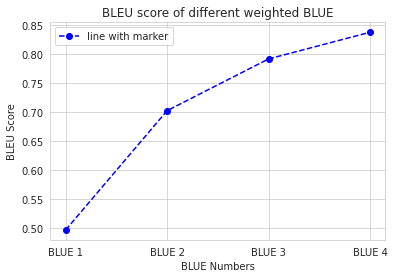

In [29]:
x = ['BLUE 1', 'BLUE 2', 'BLUE 3', 'BLUE 4']
y = np.array(total_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score of different weighted BLUE")
plt.xlabel("BLUE Numbers")
plt.ylabel("BLEU Score")
plt.plot(x, y, linestyle='--', marker='o', color='b', label='line with marker')
plt.legend()
plt.show()

In [30]:
pip install jiwer

     |████████████████████████████████| 50 kB 4.9 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149863 sha256=a08ce77fff606029789bfd6e982c813be4359cfbea8bfdf709203ee090727005
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [31]:
import jiwer
test_eng_texts = [pair[0] for pair in test_pairs]
test_hin_texts = [pair[1] for pair in test_pairs]
werlist=[]
for i in range(500):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("german : ",test_hin_texts[i])
    print("predicted: ",translated)
    werscore = jiwer.wer((test_hin_texts[i]), translated)
    print("wer:", werscore)
    werlist.append(werscore)    
    print("____________________________________________________________________________") 

1
english:  The gentleman is a very famous pianist.
german :  [start] यह महाशय बहुत जाने-माने पियानिस्ट हैं। [end]
predicted:  [start] मुश्किल में बहुत पतली है। [end]
wer: 0.625
____________________________________________________________________________
2
english:  These are very old books.
german :  [start] ये किताबें काफ़ी पुरानी हैं। [end]
predicted:  [start] ये हमारी किताबें पुस्तकालय से बहुत देर हैं। [end]
wer: 0.7142857142857143
____________________________________________________________________________
3
english:  It will take me no less than 10 hours to prepare for the exam.
german :  [start] मुझे परीक्षा की तैयारी करने के लिए कम-से-कम दस घंटे लगेंगे। [end]
predicted:  [start] आठ से पहले कई बार मिल चुका था। [end]
wer: 0.8461538461538461
____________________________________________________________________________
4
english:  Where is the south terminal?
german :  [start] दक्षिण टर्मिनल कहाँ पर है? [end]
predicted:  [start] आप कहाँ रहते हैं [end]
wer: 0.5714285714285714
_______

In [32]:
werlist

[0.625,
 0.7142857142857143,
 0.8461538461538461,
 0.5714285714285714,
 0.6666666666666666,
 0.75,
 0.6666666666666666,
 0.9285714285714286,
 0.25,
 0.8,
 0.8571428571428571,
 0.875,
 1.0,
 0.7857142857142857,
 0.5833333333333334,
 0.25,
 0.5555555555555556,
 0.1,
 0.5714285714285714,
 0.6666666666666666,
 0.9090909090909091,
 0.5714285714285714,
 0.25,
 0.75,
 0.5,
 0.125,
 0.6666666666666666,
 0.6,
 0.8181818181818182,
 0.6666666666666666,
 0.42857142857142855,
 0.1111111111111111,
 0.8,
 0.8333333333333334,
 1.2222222222222223,
 0.4,
 0.2222222222222222,
 0.75,
 1.0,
 0.6,
 0.7692307692307693,
 0.42857142857142855,
 0.42857142857142855,
 0.6666666666666666,
 0.1111111111111111,
 0.1111111111111111,
 0.5714285714285714,
 0.2222222222222222,
 0.42857142857142855,
 0.2,
 0.4,
 0.2857142857142857,
 0.625,
 0.8,
 0.6666666666666666,
 0.8333333333333334,
 0.75,
 0.8571428571428571,
 0.7692307692307693,
 0.8,
 0.7777777777777778,
 0.8,
 0.6666666666666666,
 0.8888888888888888,
 0.833333333

In [33]:
print(sum(werlist)/len(werlist))

0.6223487623487622


In [34]:
 !pip install -U nltk

     |████████████████████████████████| 1.5 MB 12.9 MB/s 
     |████████████████████████████████| 749 kB 42.2 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [35]:
from nltk.translate.meteor_score import single_meteor_score
test_eng_texts = [pair[0] for pair in test_pairs]
test_hin_texts = [pair[1] for pair in test_pairs]
metlist=[]
for i in range(500):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("german : ",test_hin_texts[i])
    print("predicted: ",translated)
    metscore = single_meteor_score(word_tokenize(test_hin_texts[i]), word_tokenize(translated))
    print("meteor score:", metscore)
    metlist.append(metscore)    
    print("____________________________________________________________________________") 

1
english:  The gentleman is a very famous pianist.
german :  [start] यह महाशय बहुत जाने-माने पियानिस्ट हैं। [end]
predicted:  [start] मुश्किल में बहुत पतली है। [end]
meteor score: 0.565083176127594
____________________________________________________________________________
2
english:  These are very old books.
german :  [start] ये किताबें काफ़ी पुरानी हैं। [end]
predicted:  [start] ये हमारी किताबें पुस्तकालय से बहुत देर हैं। [end]
meteor score: 0.7817109144542774
____________________________________________________________________________
3
english:  It will take me no less than 10 hours to prepare for the exam.
german :  [start] मुझे परीक्षा की तैयारी करने के लिए कम-से-कम दस घंटे लगेंगे। [end]
predicted:  [start] आठ से पहले कई बार मिल चुका था। [end]
meteor score: 0.3526280771789754
____________________________________________________________________________
4
english:  Where is the south terminal?
german :  [start] दक्षिण टर्मिनल कहाँ पर है? [end]
predicted:  [start] आप कहाँ रहते है

In [36]:
metlist

[0.565083176127594,
 0.7817109144542774,
 0.3526280771789754,
 0.5698720166032515,
 0.5813953488372093,
 0.44634628044766295,
 0.5447533344046279,
 0.36221818570360076,
 0.8440643218655903,
 0.4236610711430855,
 0.5305305305305306,
 0.29592406476828587,
 0.44612794612794615,
 0.41666666666666663,
 0.5480852402296139,
 0.864795918367347,
 0.6201171875000001,
 0.9268808114961962,
 0.634712600636585,
 0.5948372615039282,
 0.38999264164827085,
 0.634712600636585,
 0.8300000000000002,
 0.49486461251167135,
 0.6635108274924155,
 0.8501505541674674,
 0.5555555555555555,
 0.568544708029197,
 0.4089506172839506,
 0.6038032945736435,
 0.7349537037037036,
 0.920940170940171,
 0.5524157801418439,
 0.6657910689028086,
 0.5597014925373135,
 0.7471655328798186,
 0.8501505541674674,
 0.49486461251167135,
 0.5094310451453309,
 0.5204301075268818,
 0.4050897467420703,
 0.7145928899082569,
 0.7231040564373898,
 0.5888888888888889,
 0.9158653846153847,
 0.9335490187731471,
 0.6289424860853432,
 0.85656474

In [37]:
print(sum(metlist)/len(metlist))

0.5951331752210095
